In [160]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# Assuming X_train, X_test, y_train


data = pd.read_csv("../../data2/data.csv").drop(columns = [
    "source", "id",
    "latitude", "longitude", "SL_charbakh_subway", "SL_avan", "SL_massiv"
])

In [161]:
# Flatten the correlation matrix and reset index
correlation_matrix = data.corr()
correlation_flat = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack().reset_index()

correlation_flat.columns = ['Feature1', 'Feature2', 'Correlation']

# Sort by absolute correlation values in descending order
correlation_flat['AbsCorrelation'] = correlation_flat['Correlation'].abs()
sorted_correlations = correlation_flat.sort_values(by='AbsCorrelation', ascending=False)

# Select top 10 correlated pairs
top_10_correlated_pairs = sorted_correlations.head(60)
top_10_correlated_pairs = top_10_correlated_pairs.drop('AbsCorrelation', axis=1)

print(top_10_correlated_pairs)


                              Feature1                           Feature2  \
209                       new_building              building_type_Monolit   
34                                area                              rooms   
407                        SL_zvartnoc                SL_shengavit_subway   
590           condition_Good Condition  condition_New/Excellent Condition   
0                                price                               area   
245                         F_Internet                        F_Furniture   
387                           SL_opera               SL_baghramyan_subway   
425                SL_central_cemetery                SL_shengavit_subway   
37                                area                     bathroom_count   
155                            storeys                building_type_Stone   
270                   F_Heating System                        F_Furniture   
386                           SL_opera                SL_central_cemetery   

In [162]:
X = data.drop('price', axis=1)
y = data['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "SVM": SVR(),
    "KNN": KNeighborsRegressor(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Elastic Net": ElasticNet(),
    "Bayesian Ridge": BayesianRidge()
}

results = []
models_fitted = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results.append({"Model": name, "Mean Absolute Error": mae, "R2 Score": r2})
    models_fitted[name] = model

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2 Score', ascending=True)
results_df = results_df[results_df["R2 Score"] > 0.5]
results_df

/Users/petrostepoyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e+11, tolerance: 2.684e+09
  model = cd_fast.enet_coordinate_descent(


,Model,Mean Absolute Error,R2 Score
3,XGBoost,39904.261500,0.760666
2,Random Forest,41247.893518,0.725612
6,Ridge,54653.634731,0.636272
7,Lasso,54658.570407,0.636187
0,Linear Regression,54659.490380,0.636184
9,Bayesian Ridge,54527.613682,0.636123
8,Elastic Net,56576.920800,0.607954
1,Decision Tree,53388.483061,0.529012
5,KNN,60799.187617,0.512358


/var/folders/67/47xpns1s0zn6h8g8npsy5_q80000gn/T/ipykernel_20093/2243014811.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df['Model'], rotation=45, ha='right')


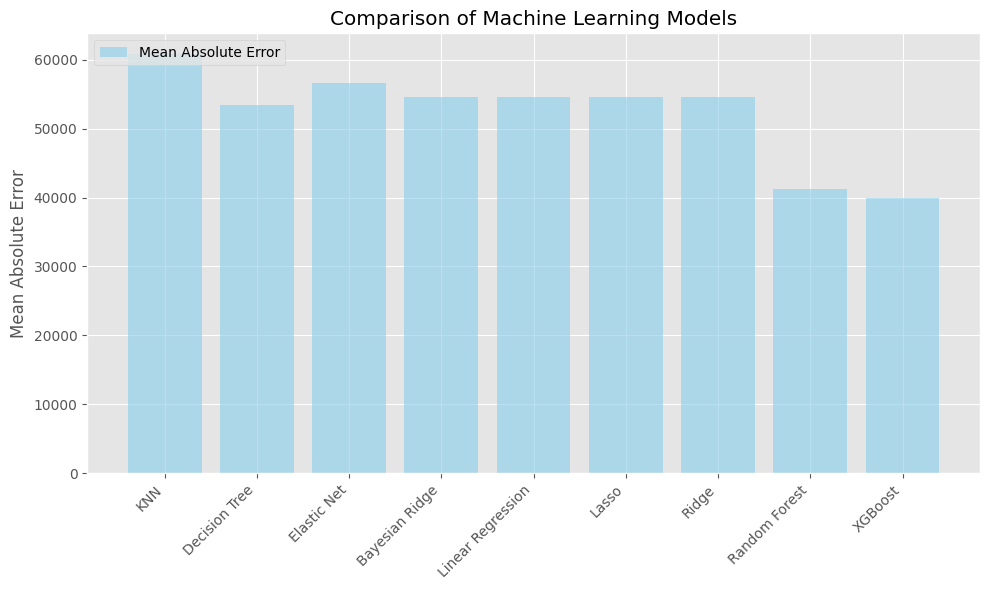

In [182]:
import matplotlib.pyplot as plt
# Plot settings
df = results_df
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting MAE with a bar chart
mae_bars = ax1.bar(df['Model'], df['Mean Absolute Error'], color='skyblue', alpha=0.6, label='Mean Absolute Error')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Mean Absolute Error')
# for tl in ax1.get_yticklabels():
#     tl.set_color('skyblue')

# Setting the x-axis labels
ax1.set_xticklabels(df['Model'], rotation=45, ha='right')


# Title and legend
plt.title('Comparison of Machine Learning Models')
ax1.legend(loc='upper left')

# Show plot
plt.tight_layout()
plt.savefig("../../visualizations/comparison_of_ML.png", dpi=800)
plt.show()

In [164]:
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf_grid = GridSearchCV(RandomForestRegressor(n_jobs=-1), rf_params, cv=3, scoring='r2')
rf_grid.fit(X_train, y_train)
rf_grid.score(X_test, y_test)

0.7405479760084956

In [165]:
xgb_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_grid = GridSearchCV(XGBRegressor(), xgb_params, cv=3, scoring='r2')
xgb_grid.fit(X_train, y_train)
xgb_grid.score(X_test, y_test)

0.7445304035612668

In [166]:
knn_params = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    "leaf_size": [30, 35, 50, 100]
}

knn_grid = GridSearchCV(KNeighborsRegressor(), knn_params, cv=3, scoring='r2')
knn_grid.fit(X_train, y_train)
knn_grid.score(X_test, y_test)

0.5603527345911732

In [167]:
dt_params = {
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(DecisionTreeRegressor(), dt_params, cv=3, scoring='r2')
dt_grid.fit(X_train, y_train)
dt_grid.score(X_test, y_test)

0.6485038322312445

# Linear Regression

In [66]:
# Generate all interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_interactions, y, test_size=0.1, random_state=42)

# # Train a linear regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Make predictions and evaluate the model
# predictions = model.predict(X_test)
# mae = mean_absolute_error(y_test, predictions)
# r2 = r2_score(y_test, predictions)

# # Output the performance metrics
# print("Mean Absolute Error:", mae)
# print("R2 Score:", r2)

In [137]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.7493273783250951

In [138]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7358221302091024

In [75]:
mean_absolute_error(xgb.predict(X_test), y_test)

49495.42101793249

In [116]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.to_numpy().reshape(-1, 1))

# Step 2: Fit the SVR model
svr = SVR(kernel='linear', C=1.0)  # You can choose a different kernel and C value if needed
svr.fit(X_train_scaled, y_train_scaled)

# Step 3: Make predictions
y_pred = svr.predict(X_test_scaled)

# Step 4: Evaluate the model (you can use any regression metric you prefer)
mse = mean_absolute_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

/Users/petrostepoyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Root Mean Squared Error: 0.6562953547746225
